# IANNWTF - Homework 05
(by Group 17 - Nils Niehaus, Philipp Bauer, Marlon Dammann)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm import tqdm

## 1 Data Set

Constructing a Data Pipeline.
We load the dataset 'fashion_mnist' as supervised:

In [2]:
train_ds, test_ds = tfds.load('fashion_mnist', split=['train', 'test'], as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete885G46/fashion_mnist-train.tfrecord


  0%|          | 0/60000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete885G46/fashion_mnist-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


and apply the appropriate preprocessing including normalizing, shuffling, prefetching and batching the data as well as onehotifying the targets:

In [3]:
def preprocess_fashion_mnist_dataset(data_split):
    '''We change the data type of the image values to float32'''
    data_split = data_split.map(lambda img, target: (tf.cast(img, 'float32'),target))
    '''We one-hotify the target and make the vector 2-dimensional'''
    data_split = data_split.map(lambda img, target: (img, tf.one_hot(target,10)))
    '''We normalize the gray-values to a range of 0-1'''
    data_split = data_split.map(lambda img, target: (img/255.,target))    
    '''We shuffle, take a batch size of 8 and prefetch 20 elements'''
    data_split = data_split.shuffle(1000)
    data_split = data_split.batch(16)
    data_split = data_split.prefetch(20)
    return data_split

In [4]:
data_train = train_ds.apply(preprocess_fashion_mnist_dataset)
data_test = test_ds.apply(preprocess_fashion_mnist_dataset)

## 2 Model

Our CNN-Model is defined as a subclass from the standard keras model and consits of 2 Convolutional layers with given parameters (ref. to homework-pdf) followed by a Global-Average-Pooling layer. Those are surrounded by a dense input layer with a shape matching that of the image-data and a dense output layer.

In [5]:
class FashionMNISTClassifier(tf.keras.Model):
    '''Our wine-classifier model with adjustable size.'''
    def __init__(self):
        '''Initializes the model with a given down/upscaling of the standard size from the last task.'''
        
        super(FashionMNISTClassifier, self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(filters=32,kernel_size=5,strides=(1,1),padding='same',activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(filters=32,kernel_size=3,strides=(1,1),padding='same',activation='relu')
        self.maxpool = tf.keras.layers.MaxPooling2D(pool_size=2,strides=2,padding='same')
        self.conv3 = tf.keras.layers.Conv2D(filters=64,kernel_size=3,strides=(1,1),padding='same',activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(filters=64,kernel_size=5,strides=(1,1),padding='same',activation='relu')
        self.avgpool = tf.keras.layers.GlobalAveragePooling2D()
        self.output_layer = tf.keras.layers.Dense(units=10, activation=tf.nn.softmax)

    def call(self, inputs):
        '''The model\'s call method for forwarding the input through the layers.'''
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.avgpool(x)
        x = self.output_layer(x)
        return x

## 3 Training

In [6]:
model_performance = {'training': {'loss' : [], 'accuracy' : []}, 
                     'test': {'loss' : [], 'accuracy' : []}}

In [7]:
dataset = {'training' : data_train, 'test' : data_test}

In [8]:
def get_loss_and_accuracy(model, data_split, loss_function, mode_name):
    '''Returns the loss and accuracy of the model on a given split of the data.'''
    accuracy_aggregator = []
    loss_aggregator = []

    for (input, target) in tqdm(data_split,desc='Sampling Loss/Accuracy for ' + str(mode_name) + ' data'):
        prediction = model(input)
        sample_loss = loss_function(target, prediction)
        sample_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_accuracy = np.mean(sample_accuracy)
        loss_aggregator.append(sample_loss.numpy())
        accuracy_aggregator.append(sample_accuracy)
    
    loss = tf.reduce_mean(loss_aggregator)
    accuracy = tf.reduce_mean(accuracy_aggregator)
    return loss, accuracy

In [9]:
def performance_test(model, data_split, loss_function, model_performance, mode_name):
    '''Evaluation of loss and accuracy of a model on a data split.'''
    loss, accuracy = get_loss_and_accuracy(model, data_split, loss_function, mode_name)
    model_performance[mode_name]['loss'].append(loss.numpy())
    model_performance[mode_name]['accuracy'].append(accuracy.numpy())
    if mode_name == 'test':
      print('Test accuracy for current epoch: ', model_performance[mode_name]['accuracy'][-1])

In [10]:
def train_step(model, input, target, loss_function, optimizer):
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [11]:
def train_model(model, dataset, optimizer, loss_function, num_epochs, model_performance):
    '''Initial performance of the model without training'''
    for data, name in zip(list(dataset.values()),list(dataset.keys())):
        performance_test(model, data, loss_function, model_performance, mode_name=name)
    
    for epoch in range(num_epochs):
        for input,target in tqdm(dataset['training'],desc='Epoch '+str(epoch+1)):
            train_step(model, input, target, loss_function, optimizer)
        for data, name in zip(list(dataset.values()),list(dataset.keys())):
            performance_test(model, data, loss_function, model_performance, mode_name=name)

In [12]:
tf.keras.backend.clear_session()

'''Hyperparameters'''
num_epochs = 10
learning_rate = 0.0001

'''Loss function'''
cat_cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()

'''Adam as chosen optimizer'''
optimizer = tf.keras.optimizers.Adam(learning_rate)

'''Model'''
model = FashionMNISTClassifier()

In [13]:
train_model(model, dataset, optimizer, cat_cross_entropy_loss, num_epochs, model_performance)

Sampling Loss/Accuracy for test data: 100%|██████████| 625/625 [00:07<00:00, 78.94it/s] 


Test accuracy for current epoch:  0.1


Sampling Loss/Accuracy for test data: 100%|██████████| 625/625 [00:06<00:00, 95.83it/s] 


Test accuracy for current epoch:  0.7547


Sampling Loss/Accuracy for test data: 100%|██████████| 625/625 [00:06<00:00, 94.60it/s] 


Test accuracy for current epoch:  0.7722


Sampling Loss/Accuracy for test data: 100%|██████████| 625/625 [00:06<00:00, 93.93it/s] 


Test accuracy for current epoch:  0.7698


Sampling Loss/Accuracy for test data: 100%|██████████| 625/625 [00:06<00:00, 94.64it/s] 


Test accuracy for current epoch:  0.7852


Sampling Loss/Accuracy for test data: 100%|██████████| 625/625 [00:10<00:00, 61.01it/s] 


Test accuracy for current epoch:  0.807


Sampling Loss/Accuracy for test data: 100%|██████████| 625/625 [00:06<00:00, 90.24it/s] 


Test accuracy for current epoch:  0.8287


Sampling Loss/Accuracy for test data: 100%|██████████| 625/625 [00:07<00:00, 88.64it/s] 


Test accuracy for current epoch:  0.834


Sampling Loss/Accuracy for test data: 100%|██████████| 625/625 [00:06<00:00, 92.50it/s] 


Test accuracy for current epoch:  0.8341


Sampling Loss/Accuracy for test data: 100%|██████████| 625/625 [00:06<00:00, 96.86it/s] 


Test accuracy for current epoch:  0.8443


Sampling Loss/Accuracy for test data: 100%|██████████| 625/625 [00:06<00:00, 92.78it/s] 

Test accuracy for current epoch:  0.8409


## 4 Visualization

Plotting the accuarcy and loss results via matplotlib.

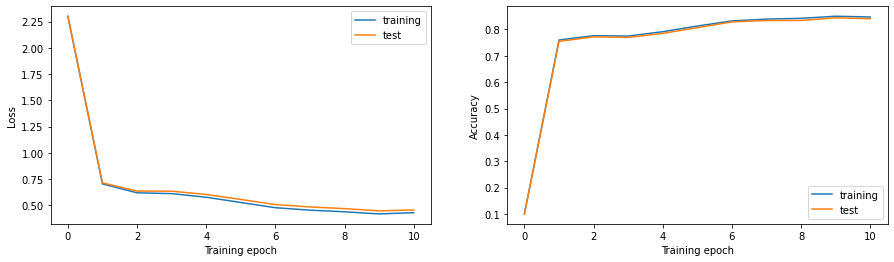

In [14]:
fig, ax = plt.subplots(1,2,figsize=(15, 4))
line1, = ax[0].plot(model_performance['training']['loss'])
line2, = ax[0].plot(model_performance['test']['loss'])
line3, = ax[1].plot(model_performance['training']['accuracy'])
line4, = ax[1].plot(model_performance['test']['accuracy'])
ax[0].set_xlabel("Training epoch")
ax[0].set_ylabel("Loss")
ax[1].set_xlabel("Training epoch")
ax[1].set_ylabel("Accuracy")
ax[0].legend((line1,line2),("training","test"))
ax[1].legend((line3,line4),("training","test"))
plt.show()

In [15]:
print('Final accuracy on test data: ',np.round(model_performance['test']['accuracy'][-1]*100,decimals=3),'%')

Final accuracy on test data:  84.09 %


We have tried mutliple times with different parameters and architectural choices but could not improve 84% accuracy within 10 epochs.  
Considering that in the sample solution by the other groups more than 10 epochs were used and that it seems likely that within the next two epochs we would also have reached the 85% benchmark, I would consider this acuraccy sufficient.  